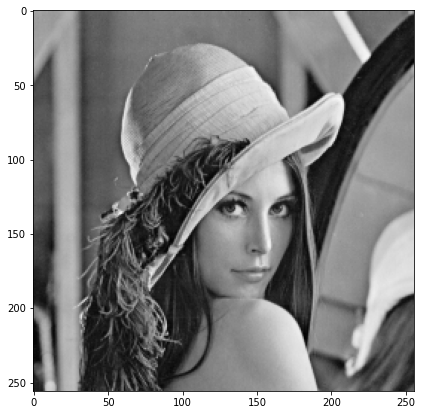

In [1]:
#Importando as bibliotecas
import time
import math
import numpy
from scipy.io import wavfile #para ler audio
from numba import njit, jit
import cv2
import matplotlib.pyplot as plt

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

plt.rcParams['figure.figsize'] = (11,7) #Definir o tamanho da imagem que vai aparecer na tela

#Lendo e mostrando a imagem
imagem = cv2.imread('resources/imgs/lena256.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(imagem, cmap = 'gray')
plt.show()

## DCT1D

In [2]:
@jit
def dct1d(x):
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]
    return result

## DCT2D

In [3]:
@jit
def dct2d(img):
    result = numpy.array(list(map(dct1d, img))).transpose()
    result = numpy.array(list(map(dct1d, result))).transpose()
    return list(result)

## Aplicando a DCT

In [4]:
img_dct = dct2d(imagem)
dc = img_dct[0][0]
print("Módulo DC =", dc)

Módulo DC = 31883.609375000007


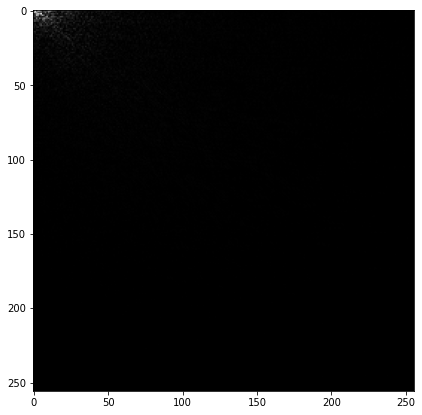

In [5]:
img_dct[0][0] = 0.0
plt.imshow(numpy.abs(img_dct), cmap="gray")
plt.show()

## DCT Normalizada

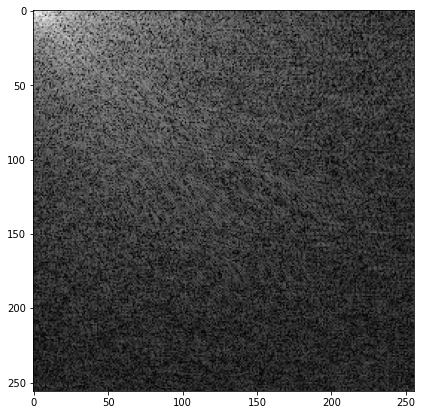

In [6]:
@jit
def dct_norm(dct):
    dct = numpy.copy(dct)
    dct_normalized = numpy.log(numpy.abs(dct) + 1)
    dct_normalized *= (255.0/dct_normalized.max())
    return list(dct_normalized)
plt.imshow(numpy.abs(dct_norm(img_dct)), cmap="gray")
plt.show()

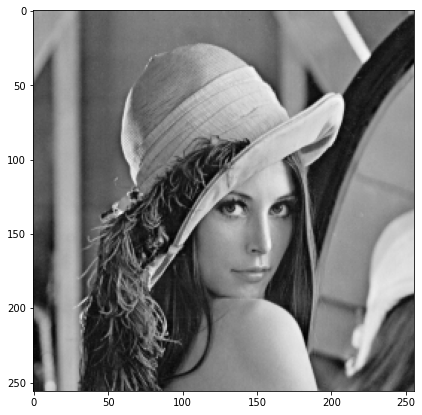

In [7]:
@jit
def idct1d(x: numpy.array) -> numpy.array:
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for n in range(N):
        x_n = 0
        for k in k_range:
            x_n += c_k[k] * x[k] * math.cos((2*n*factor[k]+factor[k]))
        x_n *= (math.sqrt(2/N))
        result[n] = x_n
    return result
@jit
def idct2d(img):
    result = numpy.array(list(map(idct1d, img))).transpose()
    result = numpy.array(list(map(idct1d, result))).transpose()
    return list(result)

plt.imshow(idct2d(img_dct), cmap="gray")
plt.show()

In [8]:
tempo_dct1 = time.time()
dct2 = dct2d(imagem)
tempo_dct2 = time.time()
tempo_dct = tempo_dct2 - tempo_dct1
print("tempo total dct:", tempo_dct)

tempo_idct1 = time.time()
idct2 = idct2d(dct2)
tempo_idct2 = time.time()
tempo_idct = tempo_idct2 - tempo_idct1
print("tempo total idct:", tempo_idct)

tempo total dct: 0.8108274936676025
tempo total idct: 0.8570871353149414


## Preservando 100 índices AC
Nesse caso n = 100.

100
[31883.609375000007, -2608.818488463658, -609.0811734528745, 2472.017894491721, 2101.0396664446284, -1144.1520189161, 1018.1795819675697, -491.59071411506335, -1074.3006439957603, -1576.5653297895817, -1920.7826236872777, -1298.6451846817617, -648.8067078189143, -948.2609839209705, -509.85631414475984, 519.8803737624835, 695.8043983266374, 676.890788798074, -516.357311672833, 1774.7127519667622, 1949.8290837843458, -1624.0820737005404, -603.9812663841492, -583.5882742467959, 809.3004215587694, -548.8120828607479, 1120.165975776208, 1103.742258914736, -535.2119832309646, 778.767088860154, -1495.2624280125215, 2006.5698422521089, -1428.680955209884, 2519.4369377077905, 476.9467678810091, -497.41321834041673, 622.5394627400287, -642.4622143095368, -554.9546812729974, -700.3066923863623, -638.7654540224497, 1934.1799074637001, -1414.621055075918, 866.8652927221127, -1695.181750344203, 767.5183043487793, -756.6124758822078, 556.3370307218715, 460.3098543758327, -625.1160520593684, 524.9

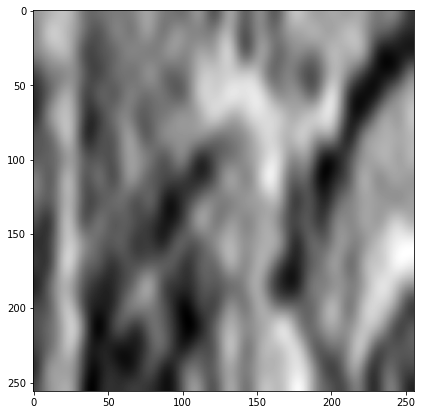

In [9]:
# Preservando nível DC
img_dct[0][0] = dc
# Separa os n níveis AC (retorna os índices da matriz como se ela fosse uma lista só) 
dct_only11 = numpy.argpartition(numpy.abs(img_dct).flatten(), -100)[-100:]
# Recupera os índices da matriz original
teste = numpy.vstack(numpy.unravel_index(dct_only11, numpy.copy(dct_norm(img_dct)).shape)).T
new_matrix = numpy.zeros((256,256))
for x in teste:
    new_matrix[x[0]][x[1]] = numpy.copy(img_dct)[x[0]][x[1]]
print(len([x for x in new_matrix.flatten() if x != 0]))
print([x for x in new_matrix.flatten() if x != 0])
plt.imshow(idct2d(new_matrix), cmap="gray")
plt.show()

## Aplicação do filtro de reforço de grave

In [10]:
#lendo audio
fs, y = wavfile.read("resources/audio/MasEstamosAiPraMais.wav")
print(f"Amostras em y: {y.shape}") #exibindo tamanho do audio
print(f"Frequencia de amostragem: {fs}") #exibindo tamanho do audio

Amostras em y: (125204,)
Frequencia de amostragem: 44100


/tmp/ipykernel_21355/1636352576.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wavfile.read("resources/audio/MasEstamosAiPraMais.wav")


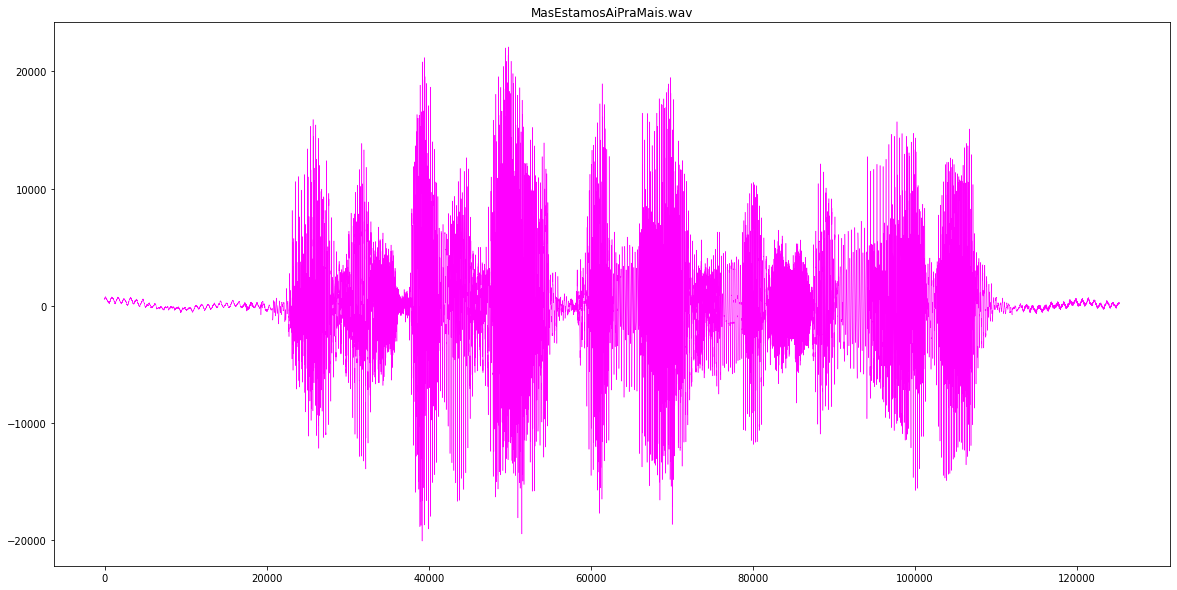

In [11]:
# Exibe o gráfico de y
def exibe_grafico(data, figsize=[20,10], color="magenta", stroke=0.5, title="MasEstamosAiPraMais.wav"):
    plt.figure('Data', figsize=figsize)
    plt.plot(data, linewidth=stroke,alpha=1,color=color)
    plt.title(title)
    plt.show()
    
exibe_grafico(y)

In [12]:
#Calcula a DCT de y e armazena o resultado em ydct
inicio = time.time()
ydct = dct1d(y)
final = time.time()
print("Tempo dct = {:3f}s" .format((final - inicio)))

Tempo dct = 421.290164s


In [13]:
#Processa ydct por um filtro passa-baixas ideal e armazena o resultado em ydctlp
ydctlp = ydct.copy()

In [14]:
#A frequência de corte é 12520 (adimensional), que corresponde a 10% da maior frequência
fc = 12520
for i in range(len(ydctlp)):
    if i > fc:
        ydctlp[i] = 0

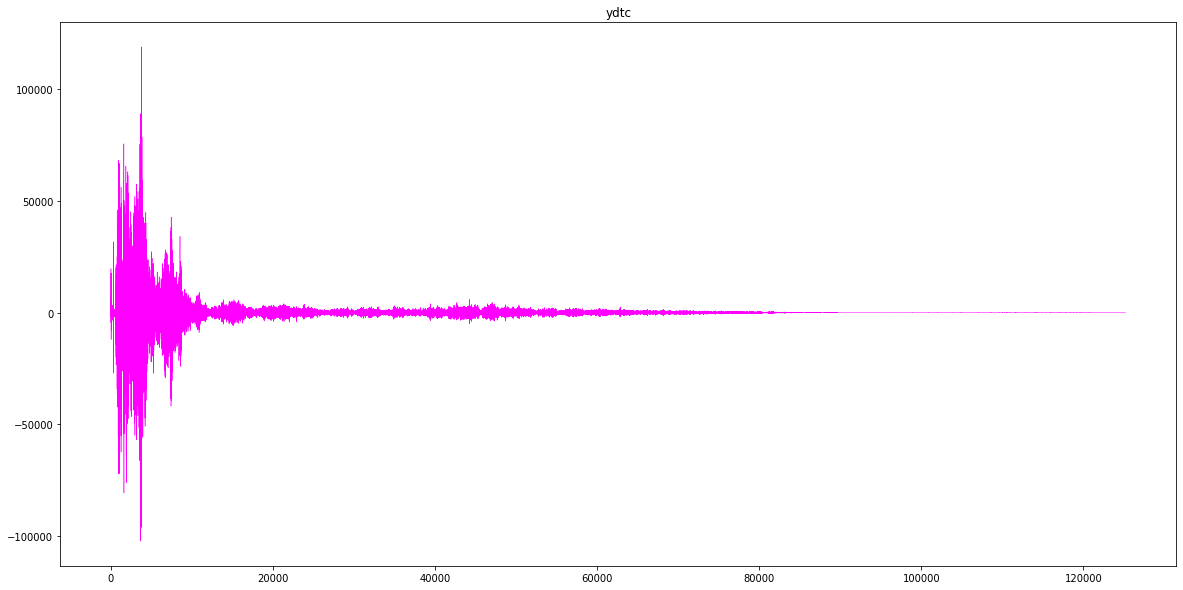

Nivel DC: 5608.1987881464665


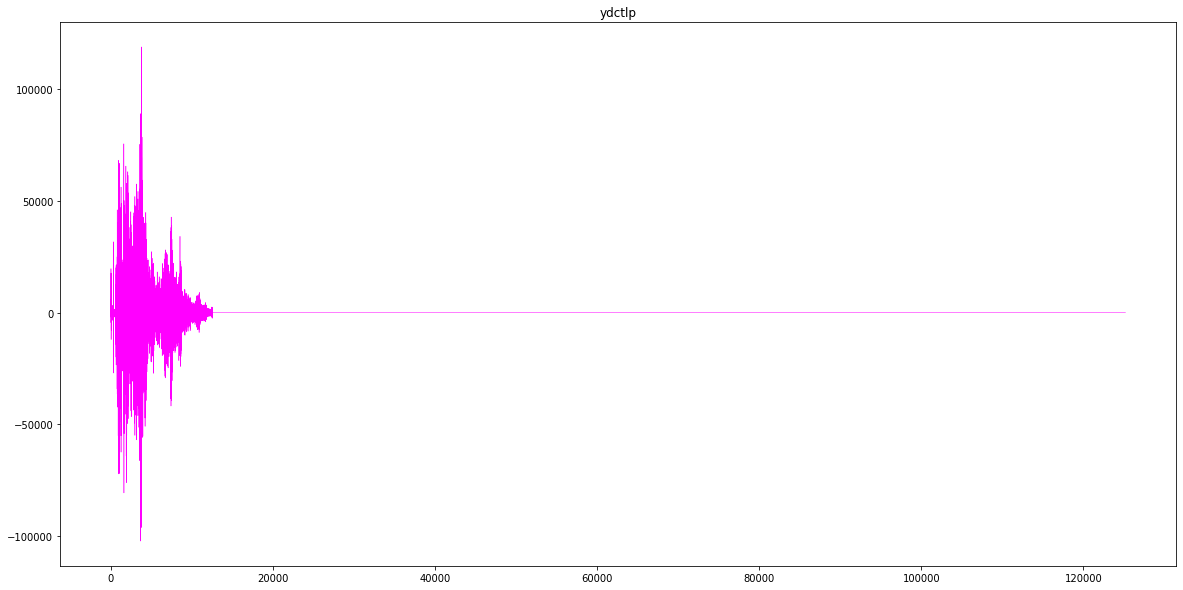

In [15]:
# fazendo comparacao do grafico do dct com o grafico do dct com filtro
exibe_grafico(ydct, title="ydtc")
print("Nivel DC: {}".format(ydct[0]))
exibe_grafico(ydctlp, title="ydctlp")

In [16]:
# Calcula a DCT inversa de ydctlp e armazena o resultado em ylp
inicio = time.time()
ylp = idct1d(ydctlp)
final = time.time()
print("Tempo ylp = {:3f}s" .format((final - inicio)))

Tempo ylp = 486.373836s


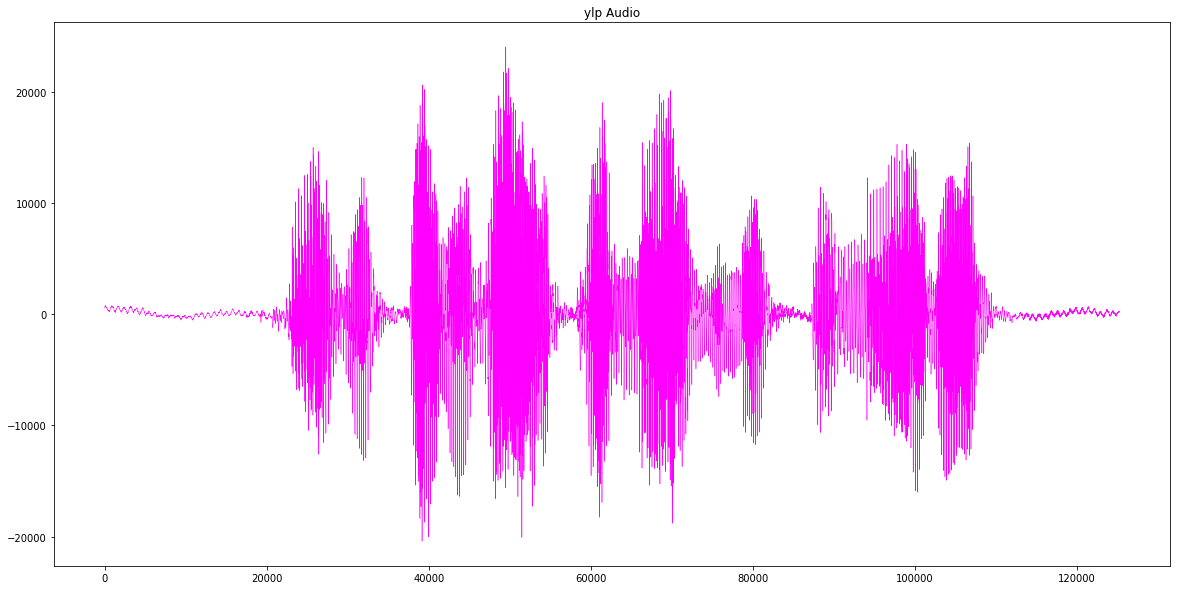

In [17]:
# plotando audio idct
exibe_grafico(ylp, title="ylp Audio")

## DCT com reforço de graves

In [18]:
@jit
def reforco_de_graves(k):
    n_y = 6
    fc = 25000
    g = 0.2
    y = g / (math.sqrt(1 + math.pow(k/fc, 2 * n_y))) + 1

    new_k = k * y

    return new_k

@jit
def dct1d_com_reforco_de_graves(x):
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*reforco_de_graves(k))/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]
    return result

In [19]:
#Calcula a DCT de y e armazena o resultado em ydct
inicio = time.time()
ydct_graves = dct1d_com_reforco_de_graves(y)
final = time.time()
print("Tempo dct com graves = {:3f}s" .format((final - inicio)))

Tempo dct com graves = 444.647470s


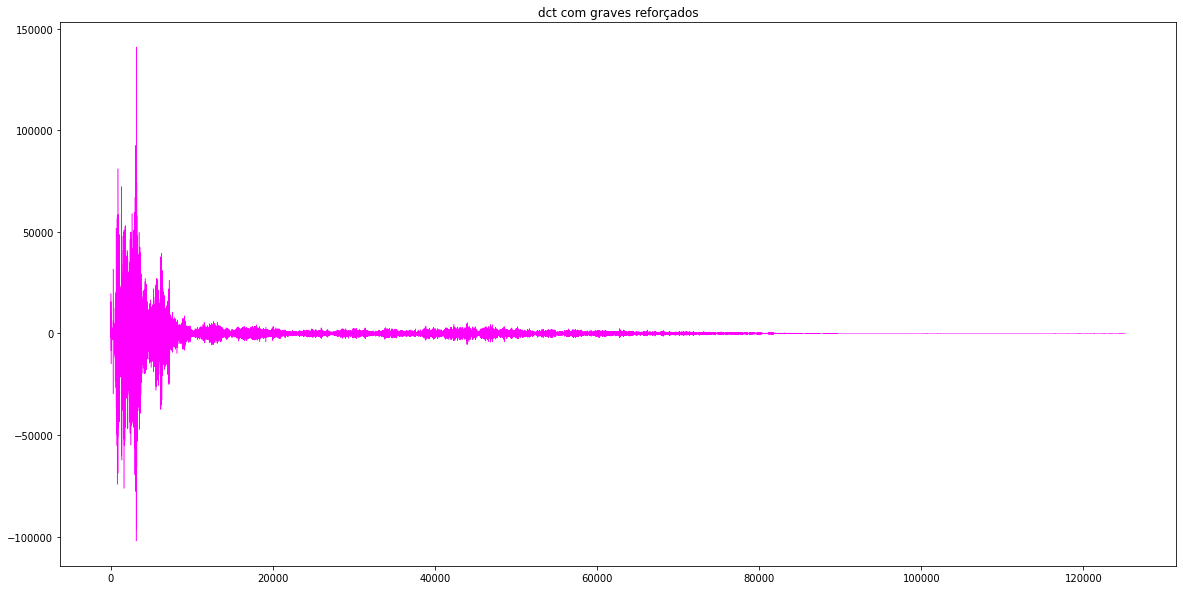

In [20]:
# plotando dct com graves reforçados
exibe_grafico(ydct_graves, title="dct com graves reforçados")

In [21]:
# Calcula a DCT inversa de ydctlp e armazena o resultado em ylp
inicio = time.time()
y_graves = idct1d(ydct_graves)
final = time.time()
print("Tempo ylp com graves = {:3f}s" .format((final - inicio)))

Tempo ylp com graves = 486.806519s


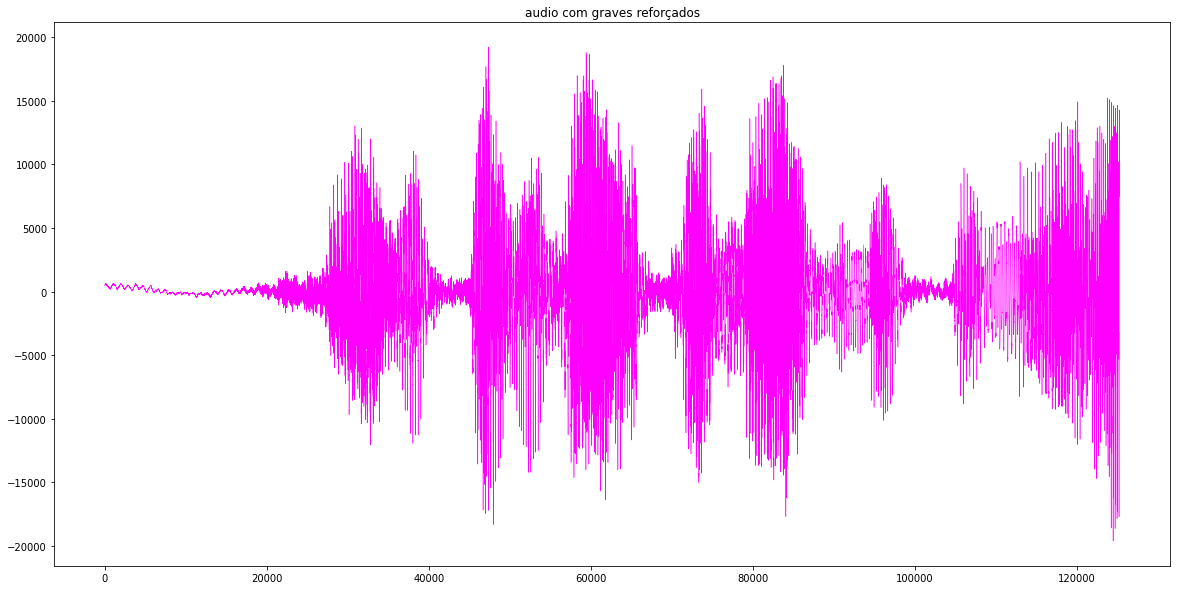

In [22]:
# plotando audio com graves reforçados
exibe_grafico(y_graves, title="audio com graves reforçados")

In [23]:
# Salva ylp no arquivo audiolp.wav
audio_tranformado = y_graves
audio_tranformado *= 1.3
audio_tranformado = audio_tranformado.astype("int16")

wavfile.write("ygraves-saida.wav", fs, audio_tranformado)